In [1]:
from __future__ import print_function
import numpy as np
import glob
import pandas as pd
from random import shuffle, seed


seed(2017)
np.random.seed(2017)

import tensorflow
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K
from keras.callbacks import EarlyStopping
%matplotlib inline
import matplotlib.pyplot as plt
#from keras.preprocessing.image import ImageDataGenerator
import cv2
WIDTH  = 64
HEIGHT = 64


batch_size = 16
num_classes = 3
epochs = 20
 
print( tensorflow.__version__,keras.__version__)

Using TensorFlow backend.


Couldn't import dot_parser, loading of dot files will not be possible.


/usr/local/lib/python2.7/dist-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


1.3.0 2.0.8


In [2]:
def build_train_set():
    
    images =  glob.glob("/disk/projects/selfdriving/shared/img4/*.jpg") 
    dataset = []
    for file in images:
        
        label = int( file.split("_")[-1].split(".")[0] )
        if label==4:
            continue
        #print(label)
        img = cv2.imread(file)
        
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize( img, (WIDTH, HEIGHT))
        
        
        ## flip image for data augmentation
        img2 = cv2.flip( img.copy(), 1 )
        #plt.imshow(img2)
        
            
        dataset.append( (np.array(img), label))
        dataset.append( (np.array(img2), label))

    shuffle(dataset)
        
    return np.array(dataset)

In [4]:
dataset = build_train_set()

len(dataset)

1010

In [5]:
r = np.random.rand( dataset.shape[0])
train = dataset[r<.8]
test = dataset[r>=.8]

In [7]:
train.shape, test.shape
x_train = np.array([ img for img in train[:,0]])
y_train = train[:,1]

x_test = np.array([ img for img in test[:,0]])
y_test = test[:,1]

In [8]:
# input image dimensions
img_rows, img_cols = WIDTH, HEIGHT


if K.image_data_format() == 'channels_first':
    input_shape = (3, img_rows, img_cols)
else:
    input_shape = (img_rows, img_cols, 3)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')


es = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=1, mode='auto')


# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test),
          callbacks =[es]
         )
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

x_train shape: (811, 64, 64, 3)
811 train samples
199 test samples
Train on 811 samples, validate on 199 samples
Epoch 1/20
811/811 [==============================] - 19s - loss: 0.8612 - acc: 0.6597 - val_loss: 1.2203 - val_acc: 0.6784
Epoch 2/20
811/811 [==============================] - 19s - loss: 0.6697 - acc: 0.7226 - val_loss: 0.5781 - val_acc: 0.7990
Epoch 3/20
811/811 [==============================] - 19s - loss: 0.4450 - acc: 0.8175 - val_loss: 0.3222 - val_acc: 0.8543
Epoch 4/20
811/811 [==============================] - 19s - loss: 0.2958 - acc: 0.8804 - val_loss: 0.2077 - val_acc: 0.9246
Epoch 5/20
811/811 [==============================] - 20s - loss: 0.1863 - acc: 0.9273 - val_loss: 0.1850 - val_acc: 0.9146
Epoch 6/20
811/811 [==============================] - 20s - loss: 0.1254 - acc: 0.9581 - val_loss: 0.1582 - val_acc: 0.9347
Epoch 7/20
811/811 [==============================] - 21s - loss: 0.0941 - acc: 0.9704 - val_loss: 0.1135 - val_acc: 0.9598
Epoch 8/20
811/811 

In [9]:
model.save("/disk/projects/selfdriving/shared/model/model_4.hd5")

In [10]:
ret = model.predict( x_train[8].reshape( 1, 64,64,3) )

In [11]:
ret

array([[  1.00000000e+00,   2.53532492e-13,   2.75134624e-12]], dtype=float32)

In [12]:
np.argmax(ret)

0

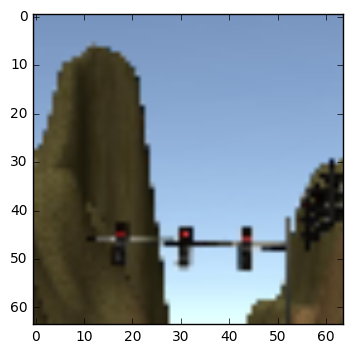

In [13]:
plt.imshow( x_train[8])

In [14]:
del model

from keras.models import load_model
model = load_model("/disk/projects/selfdriving/shared/model/model_4.hd5")

In [18]:
%time ret = model.predict( x_train[8].reshape( 1, 64,64,3) )

CPU times: user 21.5 ms, sys: 8.65 ms, total: 30.1 ms
Wall time: 10.7 ms


In [19]:
ret

array([[  1.00000000e+00,   2.53532492e-13,   2.75134624e-12]], dtype=float32)